# Figure 11

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import sys

sys.path.append('../src')

from Config.config import PATHS

import warnings
warnings.filterwarnings("ignore")

In [2]:
from Utils.interaction import Performer
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Classes.cognitive_model_agents import FocalRegionAgent, Titan

In [3]:
fixed_parameters = {
	"num_agents": 6,
	"threshold": 0.5,
}
free_parameters = {
    'inverse_temperature': 20, 
    'bias': 0.44, 
    'learning_rate': 0.3, 
    'len_history': 1, 
    'c': 0.7, 
    'delta': 0.02
}
simulation_parameters = {
	'num_rounds': 500,
    'num_episodes': 100,
	'verbose': False
}

In [4]:
df_list = []

for N in [6]:
    for delta in [0.1, 0.5]:
        for len_history in [2, 6]:
            for c in [0.5, 0.7]:
                free_parameters['c'] = c
                free_parameters['delta'] = delta
                if N == 3:
                    free_parameters['len_history'] = len_history + 1
                else:
                    free_parameters['len_history'] = len_history                
                fixed_parameters['num_agents'] = N
                raw_df = Performer.sim(
                    agent_class=Titan,
                    fixed_parameters=fixed_parameters,
                    free_parameters=free_parameters,
                    simulation_parameters=simulation_parameters
                )
                raw_df['threshold'] = fixed_parameters['threshold']
                raw_df['num_agents'] = fixed_parameters['num_agents']
                raw_df['len_history'] = free_parameters['len_history']
                raw_df['c'] = free_parameters['c']
                raw_df['delta'] = free_parameters['delta']
                raw_df['model'] = f"c={c}; len_history={free_parameters['len_history']}; num_players={N}; delta={delta}"
                df_list.append(raw_df)

raw_df = pd.concat(df_list, ignore_index=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
df_titan = raw_df.groupby(['len_history', 'c', 'delta', 'id_sim', 'round'])['score'].mean().reset_index(name='score')
df_titan['roll_score'] = df_titan['score'].rolling(window=10).mean()

Text(0.5, 0.98, 'FRA + Payoff + Attendance')

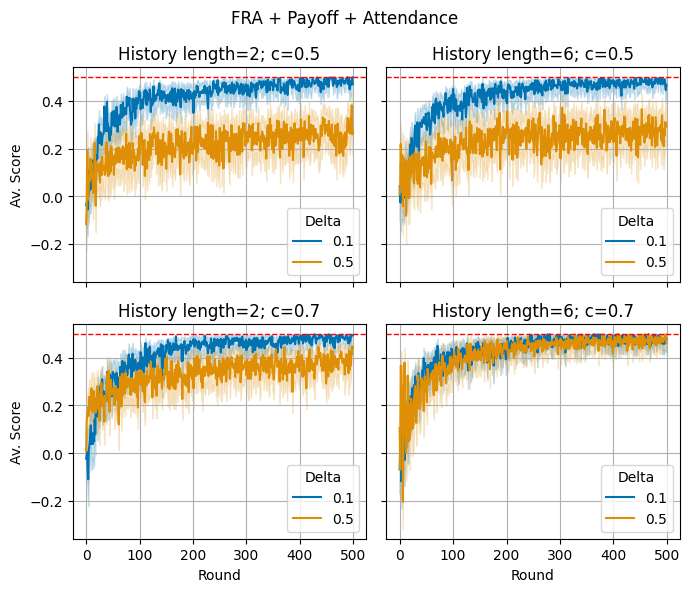

In [6]:
grid = Grid(4)
fig, axes = plt.subplots(
    grid.rows, grid.cols,
    figsize=(grid.cols * 3.5, grid.rows * 3),
    tight_layout=True,
    sharex=True, sharey=True    
)

sns.lineplot(
    x='round', y='score', hue='delta', palette='colorblind',
    data=df_titan[(df_titan['len_history'] == 2) & (df_titan['c'] == 0.5)], 
    ax=axes[0, 0]
)
axes[0, 0].set_title('History length=2; c=0.5')
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1)

sns.lineplot(
    x='round', y='score', hue='delta', palette='colorblind',
    data=df_titan[(df_titan['len_history'] == 6) & (df_titan['c'] == 0.5)], 
    ax=axes[0, 1]
)
axes[0, 1].set_title('History length=6; c=0.5')
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1)

sns.lineplot(
    x='round', y='score', hue='delta', palette='colorblind',
    data=df_titan[(df_titan['len_history'] == 2) & (df_titan['c'] == 0.7)], 
    ax=axes[1, 0]
)
axes[1, 0].set_title('History length=2; c=0.7')
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1)

sns.lineplot(
    x='round', y='score', hue='delta', palette='colorblind',
    data=df_titan[(df_titan['len_history'] == 6) & (df_titan['c'] == 0.7)], 
    ax=axes[1, 1]
)
axes[1, 1].set_title('History length=6; c=0.7')
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1)

for f, c in grid:
    axes[f, c].set_xlabel('Round')
    axes[f, c].set_ylabel('Av. Score')
    axes[f, c].legend(title='')
    axes[f, c].grid()
    axes[f, c].legend(title='Delta')

fig.suptitle('FRA + Payoff + Attendance')


fig.savefig(PATHS['figures_for_paper'] / 'Figure10.png', dpi=300, bbox_inches='tight')

In [7]:
gm = GetMeasurements(raw_df, ['bounded_efficiency', 'inequality'])
idx = AlternationIndex.from_file()
df = gm.get_measurements()
df = idx.alt_precentage(df, columns=['model']).reset_index()
df['c'] = df['model'].apply(lambda x: x.split(';')[0].split('=')[1])
df['len_history'] = df['model'].apply(lambda x: x.split(';')[1].split('=')[1])
df['num_players'] = df['model'].apply(lambda x: x.split(';')[2].split('=')[1])
df['delta'] = df['model'].apply(lambda x: x.split(';')[3].split('=')[1])
df['alternation_percentage'] = df['alternation_percentage'] * 100
alt_table = pd.pivot_table(
    data=df,
    index=['c'],
    values=['alternation_percentage'],
    columns=['len_history', 'delta']
).fillna('-')
alt_table

alternation_percentage               
len_history                      2         6     
delta                          0.1  0.5  0.1  0.5
c                                                
0.5                            2.0  0.0  1.0  0.0
0.7                            0.0  0.0  0.0  0.0

In [8]:
print(alt_table.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{alternation_percentage} \\
len_history & \multicolumn{2}{r}{2} & \multicolumn{2}{r}{6} \\
delta & 0.1 & 0.5 & 0.1 & 0.5 \\
c &  &  &  &  \\
\midrule
0.5 & 2.000000 & 0.000000 & 1.000000 & 0.000000 \\
0.7 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



---